In [1]:
%load_ext autoreload
%autoreload 2

# change directory to repo root, and verify
%cd '../'
!pwd

/cephyr/users/markpett/Alvis/satellite_poverty_prediction
/cephyr/users/markpett/Alvis/satellite_poverty_prediction


In [2]:
import numpy as np
import pandas as pd
import argparse
import json
import os
import pickle
import scipy.spatial
import time

data_dir = '/cephyr/NOBACKUP/groups/globalpoverty1/data'
fold_config = 'incountry'
fold = 'A'

In [3]:
df = pd.read_csv(os.path.join(data_dir, 'dhs_clusters.csv'), float_precision='high', index_col=False)

Load cross validation folds from pkl files

In [4]:
# get train, val, test fold
folds_file_path = os.path.join(data_dir, 'folds', fold_config + '.pkl')
with open(folds_file_path, 'rb') as pickle_file:
    content = pickle.load(pickle_file)

Train a decision tree using the same splits as the deep models

In [5]:
def get_pred(x, means):
    try:
        pred = means[tuple(x)]
    except KeyError:
        pred = None
    return pred

df[['preds', 'rural_preds']] = None

for fold in 'ABCDE':
    train_i = content[fold]['train']
    val_i = content[fold]['val']
    test_i = content[fold]['test']
    
    # Since no validation, use val data for training
    train_i = np.concatenate((train_i, val_i))
    train_df = df.iloc[train_i]
    
    test_df = df.iloc[test_i]
    #print(test_df)
    
    # Get mean preds for each survey (without urban/rural split)
    means = train_df.groupby(['country', 'survey_start_year'])['iwi'].mean()
    preds = test_df[['country', 'survey_start_year']].apply(get_pred, means=means, axis=1)
    df.iloc[test_i, df.columns.get_loc('preds')] = preds.values
    
    # Get mean preds for each survey (with urban/rural split)
    means = train_df.groupby(['country', 'survey_start_year', 'rural'])['iwi'].mean()
    preds = test_df[['country', 'survey_start_year', 'rural']].apply(get_pred, means=means, axis=1)
    df.iloc[test_i, df.columns.get_loc('rural_preds')] = preds

Plot performance of the two trees trained with same splits as deep models

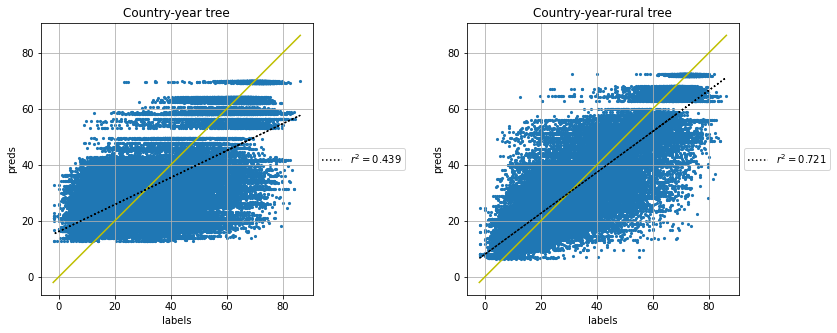

In [6]:
from utils.plot import scatter_preds
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

results_df = df.dropna()
labels, preds, rural_preds = results_df['iwi'].values.astype('float'), results_df['preds'].values.astype('float'), results_df['rural_preds'].values.astype('float')
scatter_preds(labels, preds, ax=axs[0], title='Country-year tree')
scatter_preds(labels, rural_preds, ax=axs[1], title='Country-year-rural tree')
#scatter_preds(labels, preds, by_name=None, by_col=None, ax=axs[i, j],
#                  title=title, figsize=(5, 5))

## New splits

Since there are no images that can overlap, we don't have the same "overlap"-constraint as the deep models when creating splits for the decision trees. Try creating new splits

In [7]:
def split_group(g):
    g = g.sample(frac=1, random_state=1337)
    fold_data = np.array_split(g, 5)
    for data, fold in zip(fold_data, 'ABCDE'):
        data['fold'] = fold
    return pd.concat(fold_data)
    
# split_group(df[(df['country'] == 'burundi') & (df['survey_start_year'] == 2016) & df['rural']])
new_df = df.groupby(['country', 'survey_start_year', 'rural']).apply(split_group).reset_index(drop=True)
new_df

,country,survey_start_year,year,lat,lon,GID_1,GID_2,households,rural,iwi,preds,rural_preds,fold
0,angola,2006,2006,-8.920590,13.167638,AGO.11,AGO.11.7,23,0,56.100542,17.265248,40.239569,A
1,angola,2006,2006,-12.169283,13.859255,AGO.2,AGO.2.9,20,0,68.096300,28.405477,48.9001,A
2,angola,2006,2006,-8.986261,13.317164,AGO.11,AGO.11.9,22,0,69.827324,17.265248,40.239569,A
3,angola,2006,2006,-8.977790,13.306006,AGO.11,AGO.11.9,24,0,61.795403,17.265248,40.239569,A
4,angola,2006,2006,-14.737177,13.828838,AGO.10,AGO.10.10,17,0,35.862957,29.52002,51.665705,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57190,zimbabwe,2015,2015,-20.876091,30.221715,ZWE.10,ZWE.10.6,27,1,24.161808,39.50263,25.84341,E
57191,zimbabwe,2015,2015,-19.585089,29.026045,ZWE.8,ZWE.8.2,22,1,23.137674,36.904336,25.320167,E
57192,zimbabwe,2015,2015,-17.551777,31.197354,ZWE.5,ZWE.5.2,28,1,36.546732,36.904336,25.320167,E
57193,zimbabwe,2015,2015,-20.077441,27.218075,ZWE.9,ZWE.9.2,25,1,21.987872,36.904336,25.320167,E


Make new decision trees using new splits

In [8]:
for fold in 'ABCDE':
    train_df = new_df[new_df['fold'] != fold]
    test_df = new_df[new_df['fold'] == fold]
    test_i = test_df.index
    #print(test_df)
    
    # Get mean preds for each survey (without urban/rural split)
    means = train_df.groupby(['country', 'survey_start_year'])['iwi'].mean()
    preds = test_df[['country', 'survey_start_year']].apply(get_pred, means=means, axis=1)
    new_df.iloc[test_i, new_df.columns.get_loc('preds')] = preds.values
    
    # Get mean preds for each survey (with urban/rural split)
    means = train_df.groupby(['country', 'survey_start_year', 'rural'])['iwi'].mean()
    preds = test_df[['country', 'survey_start_year', 'rural']].apply(get_pred, means=means, axis=1)
    new_df.iloc[test_i, new_df.columns.get_loc('rural_preds')] = preds
    
new_df

,country,survey_start_year,year,lat,lon,GID_1,GID_2,households,rural,iwi,preds,rural_preds,fold
0,angola,2006,2006,-8.920590,13.167638,AGO.11,AGO.11.7,23,0,56.100542,26.679887,49.330224,A
1,angola,2006,2006,-12.169283,13.859255,AGO.2,AGO.2.9,20,0,68.096300,26.679887,49.330224,A
2,angola,2006,2006,-8.986261,13.317164,AGO.11,AGO.11.9,22,0,69.827324,26.679887,49.330224,A
3,angola,2006,2006,-8.977790,13.306006,AGO.11,AGO.11.9,24,0,61.795403,26.679887,49.330224,A
4,angola,2006,2006,-14.737177,13.828838,AGO.10,AGO.10.10,17,0,35.862957,26.679887,49.330224,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57190,zimbabwe,2015,2015,-20.876091,30.221715,ZWE.10,ZWE.10.6,27,1,24.161808,39.105837,26.225292,E
57191,zimbabwe,2015,2015,-19.585089,29.026045,ZWE.8,ZWE.8.2,22,1,23.137674,39.105837,26.225292,E
57192,zimbabwe,2015,2015,-17.551777,31.197354,ZWE.5,ZWE.5.2,28,1,36.546732,39.105837,26.225292,E
57193,zimbabwe,2015,2015,-20.077441,27.218075,ZWE.9,ZWE.9.2,25,1,21.987872,39.105837,26.225292,E


Plot performance of the two trees trained with the new splits

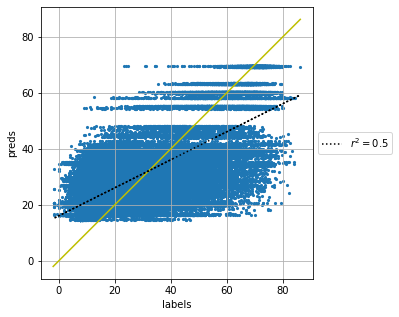

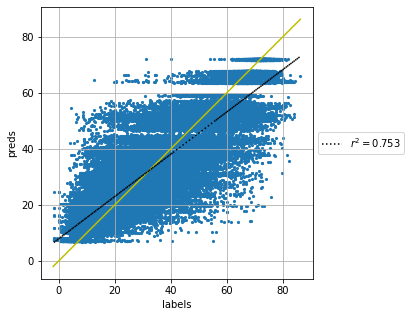

In [9]:
results_df = new_df.dropna()
labels, preds, rural_preds = results_df['iwi'].values.astype('float'), results_df['preds'].values.astype('float'), results_df['rural_preds'].values.astype('float')
scatter_preds(labels, preds)
scatter_preds(labels, rural_preds)

## Doing OOC

In [4]:
means = df.groupby(['country', 'survey_start_year', 'rural'])['iwi'].mean()
preds = df[['country', 'survey_start_year', 'rural']].apply(lambda x: means[tuple(x)], axis=1)

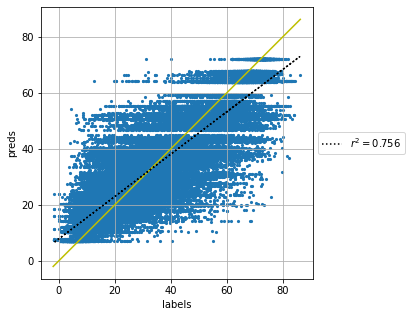

In [7]:
from utils.plot import scatter_preds
import matplotlib.pyplot as plt

labels = df['iwi'].values.astype('float')
scatter_preds(labels, preds)

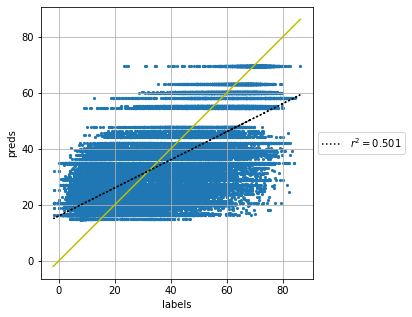

In [8]:
means = df.groupby(['country', 'survey_start_year'])['iwi'].mean()
preds = df[['country', 'survey_start_year']].apply(lambda x: means[tuple(x)], axis=1)
scatter_preds(labels, preds)

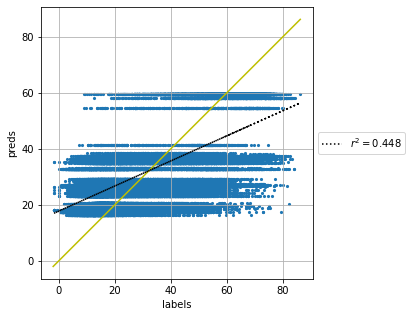

In [11]:
means = df.groupby(['country'])['iwi'].mean()
preds = df['country'].apply(lambda x: means[x])
scatter_preds(labels, preds)

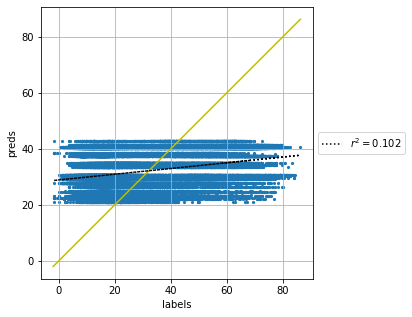

In [12]:
means = df.groupby(['year'])['iwi'].mean()
preds = df['year'].apply(lambda x: means[x])
scatter_preds(labels, preds)